# SkimLit NLP Project

Written By: Alexander Wang

Date: August 25th, 2023

This project intends to build an NLP model to make reading medical abstracts easier.

It will take in medical papers as input and classify information under categories of: Background, Objectives, Methods, Results, and Conclusions.

It utilizes the PubMed 200k RCT Dataset described in *PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts* (https://arxiv.org/abs/1710.06071)

In [2]:
from helper_functions import calculate_results

In [3]:
# Start our experiment using the 200k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

## Preprocess Data

### Preprocess Data - Visualized

In [4]:
# Create function to read the lines of a document
def get_lines(filename):
    """
    Reads filename and returns the lines of text as a list
    """
    
    with open(filename, "r") as f:
        return f.readlines()

In [5]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read lines
train_lines[:20]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [6]:
len(train_lines)

2593169

### Convert .csv to Dictionaries

Let's think about how we want our data to look...

[{'line_number': 0,

'target': 'BACKGROUND',

'text': 'Emotional eating is associated with overeating and the development of obesity .\n'

'total_lines': 11}]


Let's write a function which turns each of our datasets into the above format

In [7]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.
    """
    
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts
    
    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"): # Check to see if the line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string if the line is an ID line
        elif line.isspace(): # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
            
            # Iterate through each line in a single abstact and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # Create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") # Split target label from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
                line_data["total_lines"] = len(abstract_line_split)-1 # How many total lines are ine abstract (-1 because we want to start at 0)
                abstract_samples.append(line_data) # add line data to abstract samples list
        else: # If the above conditions are not fulfilled , the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples

In [8]:
%%time
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

2211861 28932 29493
CPU times: total: 4.19 s
Wall time: 4.18 s


In [9]:
# Check the first abstract of our training data
train_samples[:13]

[{'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'line_number': 3,
  'total_lines': 10},
 {'target': 'METHODS',
  '

### Convert Dictionaries to Pandas DataFrame

Now let's turn it into a DataFrame to further visualize it.

In [10]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


In [11]:
# Distribution of labels in training data
train_df.target.value_counts()

target
RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

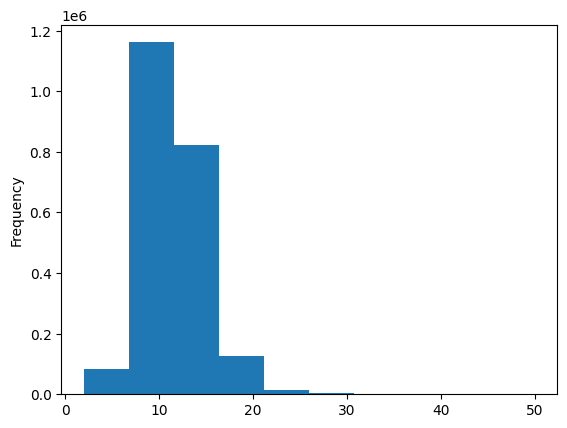

In [12]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Convert DataFrame to Lists

In [13]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(2211861, 28932, 29493)

In [14]:
# View the 10 lines of training sentences
train_sentences[:10]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'primary outcomes are domain sp

### One-Hot Encode Labels

In [15]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # Set this to false as it will output a sparse matrix datatype which is incompatible with TensorFlow (one-hot matrix made mostly of zeroes)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one-hot encoded labels look like
train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

### Label Encode Labels

In [16]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [17]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Multinomial Naive Bayes (baseline)

### Create Model

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

### Evaluate Model

In [19]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7497580533665146

In [20]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 4, 4, ..., 4, 4, 1])

In [21]:
val_labels_encoded

array([0, 4, 4, ..., 4, 1, 1])

In [22]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 74.97580533665146,
 'precision': 0.7431966265737352,
 'recall': 0.7497580533665146,
 'f1': 0.7389570175489825}

## Preprocess Data Pt2: Deep Sequence Models

### Preprocessing Pt2 - Visualized

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [24]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.229355280462922

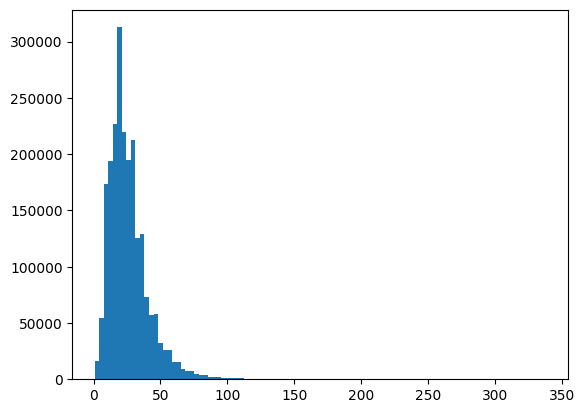

In [25]:
# What's the distribution like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=100); # bins is the 'resolution' of the bars

In [26]:
# How long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

54

In [27]:
# Maximum sequence length in the training set
max(sent_lens)

338

### Text Vectorization (Token-Level)

In [28]:
# How many words are in our vocabulary? (taken from Table 2 from the PubMed paper)
max_tokens = 68000

In [29]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                   output_sequence_length=output_seq_len)

In [30]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [31]:
# Test out text vectorizer on random sentences
import random
target_sequence = random.choice(train_sentences)
print(f"Text:\n{target_sequence}")
print(f"\nLength of Text: {len(target_sequence)}")
print(f"\nVectorized Text: {text_vectorizer([target_sequence])}")

Text:
a significant reduction in plasma oxymorphone levels did not substantially alter the pharmacodynamic effects of oxycodone .

Length of Text: 123

Vectorized Text: [[    8    33   155     5   171 12247    77    98    27  2162  2069     2
   2784    58     3  3456     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]]


In [32]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 68000
Most common words in the vocabulary: ['', '[UNK]', 'the', 'of', 'and']
Least common words in the vocabulary: ['resite', 'residentmonths', 'rescueeligible', 'rescheduling', 'resc']


May not be 68000 for vocabulary because numbers are removed.

In [33]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 54,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Embedding (Token-Level)

In [34]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [35]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sequence}\n")
vectorized_sentence = text_vectorizer([target_sequence])
print(f"Sentence after vectorization:\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 a significant reduction in plasma oxymorphone levels did not substantially alter the pharmacodynamic effects of oxycodone .

Sentence after vectorization:
 [[    8    33   155     5   171 12247    77    98    27  2162  2069     2
   2784    58     3  3456     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.04718659  0.00132645  0.00195112 ... -0.01720245 -0.04608278
   -0.02388762]
  [ 0.02695073 -0.01270392 -0.00622638 ... -0.0375638   0.01110689
    0.01948956]
  [ 0.03412539  0.04304037 -0.02882645 ...  0.0218941   0.03191281
   -0.01278884]
  ...
  [-0.00832491  0.00633172  0.04731054 ...  0.03793342 -0.01458653
   -0.02650723]
  [-0.00832491  0.00633172  0.04731054 ...  0.03793342 -0.01458653
   -0.02650723]
  [-0.00832491  0.00633172 

### Build Dataset Pipeline (Token-Level)

In [36]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [37]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # We don't shuffle data here because order matters for this project (line 1, 2, ...)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Text Vectorization (Character-Level)

In [38]:
train_sentences[:5]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .']

In [39]:
" ".join(list(train_sentences[0]))

't h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .'

In [40]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

In [41]:
# Split sequence-level data splits into character-level splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .',
 't h i s   p a p e r   d e s c r i b e s   t h e   d e s i g n   a n d   e v a l u a t i o n   o f   p o s i t i v e   o u t l o o k   ,   a n   o n l i n e   p r o g r a m   a i m i n g   t o   e n h a n c e   t h e   s e l f - m a n a g e m e n t   s k i l l s   o f   g a y   m e n   l i v i n g   w i t h   h i v   .',
 't h i s   s t u d y   i s   d e s i g n e d   a s   a   r a n d o m i s e d   c o n t r o l l e d   t r i a l   i n   w h i c h   m e n   l i v i n g   w i t h   h i v   i n   a u s t r a l i a   w i l l   b e   a s s 

In [42]:
# What's the average char length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

147.82646377869133

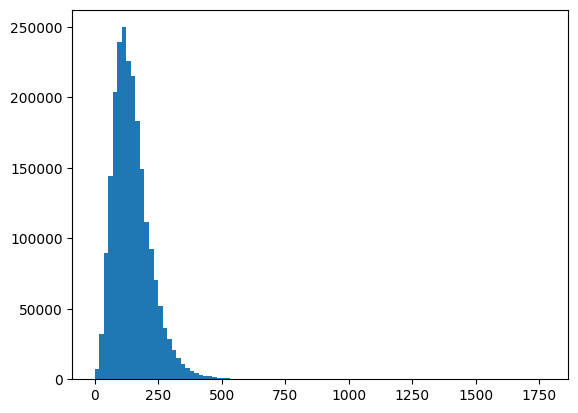

In [43]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=100);

In [44]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

284

In [45]:
# Get all keyboard characters 
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [46]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # Add 2 for space and OOV token (Out of Vocab) [UNK]
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer") # Set standardization to None if you want to leave punctuation in

In [47]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [48]:
# Check vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common chars: {char_vocab[:5]}")
print(f"5 least common chars: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common chars: ['', '[UNK]', 'e', 't', 'a']
5 least common chars: ['k', 'x', 'z', 'q', 'j']


In [49]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
c h a n g e s   i n   d n a   m e t h y l a t i o n   h a v e   b e e n   a s s o c i a t e d   w i t h   t r a f f i c - r e l a t e d   a i r   p o l l u t i o n   i n   o b s e r v a t i o n a l   s t u d i e s   ,   b u t   t h e   s p e c i f i c   m e c h a n i s m s   a n d   t e m p o r a l   d y n a m i c s   t h e r e i n   h a v e   n o t   b e e n   e x p l o r e d   i n   a   c o n t r o l l e d   s t u d y   o f   a s t h m a t i c s   .

Length of random_train_chars: 195

Vectorized chars:
[[12 13  4  6 18  2  9  5  6 10  6  4 15  2  3 13 19 11  4  3  5  7  6 13
   4 21  2 22  2  2  6  4  9  9  7 12  5  4  3  2 10 20  5  3 13  3  8  4
  17 17  5 12  8  2 11  4  3  2 10  4  5  8 14  7 11 11 16  3  5  7  6  5
   6  7 22  9  2  8 21  4  3  5  7  6  4 11  9  3 16 10  5  2  9 22 16  3
   3 13  2  9 14  2 12  5 17  5 12 15  2 12 13  4  6  5  9 15  9  4  6 10
   3  2 15 14  7  8  4 11 10 19  6  4 15  5 12  9  3 13  2  8  2  5  6 13
   4 21  2  6  7  3 22  2  2  

### Embedding (Character-Level)

In [50]:
# Create a char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # of different characters
                              output_dim=25, # from paper (maybe because there are 26 letters?)
                              mask_zero=True,
                              name="char_embed")
                              

In [51]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 c h a n g e s   i n   d n a   m e t h y l a t i o n   h a v e   b e e n   a s s o c i a t e d   w i t h   t r a f f i c - r e l a t e d   a i r   p o l l u t i o n   i n   o b s e r v a t i o n a l   s t u d i e s   ,   b u t   t h e   s p e c i f i c   m e c h a n i s m s   a n d   t e m p o r a l   d y n a m i c s   t h e r e i n   h a v e   n o t   b e e n   e x p l o r e d   i n   a   c o n t r o l l e d   s t u d y   o f   a s t h m a t i c s   .

Embedded chars. (after vectorization and embedding):
 [[[-0.03716042 -0.00717834  0.03744062 ... -0.01155217  0.03157032
   -0.00721451]
  [-0.01967531 -0.04076372  0.04015574 ... -0.00067635 -0.02292938
    0.04754019]
  [ 0.02083217 -0.03287131 -0.03093755 ... -0.02631461 -0.00776676
    0.03782732]
  ...
  [-0.02838322  0.01234788  0.04041245 ...  0.03050805 -0.03185584
    0.03940972]
  [-0.02838322  0.01234788  0.04041245 ...  0.03050805 -0.03185584
    0.03940972]
  [-0.02838322  0.01234788  0.04041245 ...  0.03050

### Build Dataset Pipeline (Character-Level)

In [52]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Build Dataset Pipeline (Token + Character Level)

In [53]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data (THIS MUST BE THE SAME ORDER AS inputs=[token_model.input, char_model.input]
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [54]:
# Repeat the above steps with validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [55]:
# Check out our training data and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Text Vectorization (Positional-Level)

In [56]:
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10


> **Note** Any engineered features used to train a model must be available at test time. In our case, line numbers and total lines are available.

In [57]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     190654
1     190654
2     190654
3     190644
4     190357
5     189080
6     185551
7     177967
8     164187
9     143835
10    117871
11     90168
12     64864
13     44350
14     29186
15     18785
16     11803
17      7392
18      4688
19      3030
20      1925
21      1268
22       814
23       564
24       398
25       288
26       214
27       159
28       118
29        88
30        64
31        55
32        42
33        34
34        21
35        17
36        12
37         9
40         6
38         6
39         6
41         5
42         5
43         5
44         4
45         4
46         3
47         2
48         2
49         2
50         1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

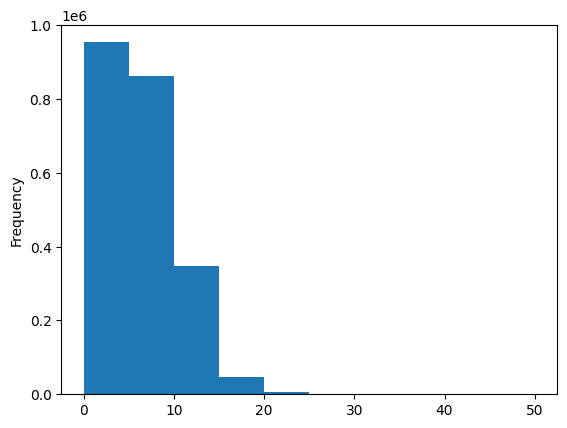

In [58]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [59]:
# Use TensorFlow to create one-hot encoded tensors of our line number column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15) # 15 chosen because it covers most of the dataset, (having too big of an encoding is bad for computation)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([2211861, 15]))

We want to one-hot encode this value because we don't want our model to think that line number 2 has twice the weight as line number 1 
* This is because when we one-hot encode it, it acts as a "token vectorizer". We will then pass it into a Dense layer that acts as an embedding layer in the model.
* We don't want the Dense layer to treat those higher values with more weight. We want each to be equal. 

Let's to the same for our total lines feature

In [60]:
# How many different number of lines are there
train_df["total_lines"].value_counts()

total_lines
10    304733
11    303648
12    266682
9     259640
13    212296
8     183168
14    156015
15    111712
7     110240
16     74987
6      53088
17     48672
18     31502
19     22100
5      21174
20     13797
21      9988
4       6385
22      5750
23      3984
24      2750
25      1924
26      1485
27      1148
3       1148
28       870
29       720
33       442
31       416
30       279
32       264
35       180
34       140
37       114
36       111
50        51
49        50
46        47
45        46
43        44
40        41
2         30
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

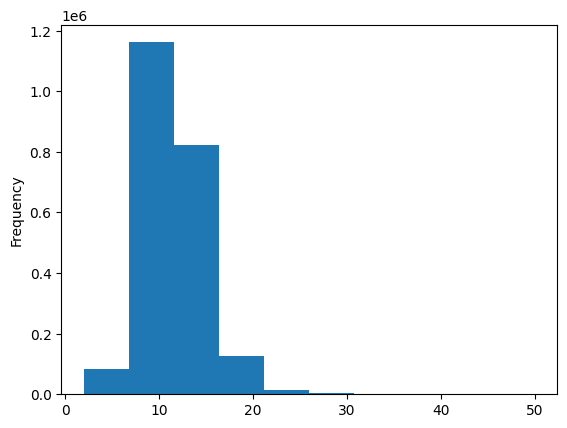

In [61]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [62]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [63]:
# Use TensorFlow to create one-hot encoded tensors of our total lines feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0

### Build Dataset Pipeline (Token + Character + Positional)

In [64]:
# Creating training and validation datasets (with all 4 different kinds of inputs)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [65]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Model 1: Conv1D (CNN - Token Embedding)

### Create Model

In [66]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [67]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 54)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 54, 128)          8704000   
                                                                 
 conv1d (Conv1D)             (None, 54, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [68]:
# Batch size
len(train_dataset)

69121

Too many batches! Let's look at 10% of this dataset to run experiments faster (When scaling models to find the best, you should be able to run experiments every 5 minutes)

In [69]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
6912/6912 [==============================] - 55s 7ms/step - loss: 0.5900 - accuracy: 0.7892 - val_loss: 0.5084 - val_accuracy: 0.8160
Epoch 2/3
6912/6912 [==============================] - 52s 7ms/step - loss: 0.5032 - accuracy: 0.8222 - val_loss: 0.4733 - val_accuracy: 0.8302
Epoch 3/3
6912/6912 [==============================] - 52s 8ms/step - loss: 0.4813 - accuracy: 0.8299 - val_loss: 0.4574 - val_accuracy: 0.8333


### Evaluate Model

In [70]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

905/905 [==============================] - 2s 2ms/step - loss: 0.4633 - accuracy: 0.8362


[0.4632856845855713, 0.836167573928833]

In [71]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[8.8339651e-01, 2.7701638e-03, 6.4596925e-06, 1.1382154e-01,
         5.2990595e-06],
        [1.2069642e-02, 6.4483266e-03, 8.9464235e-01, 9.8573156e-03,
         7.6982297e-02],
        [1.0655625e-03, 1.2574568e-01, 3.9092153e-03, 2.0087614e-04,
         8.6907864e-01],
        ...,
        [6.2904821e-04, 4.1761100e-01, 9.1323302e-05, 1.3119965e-04,
         5.8153743e-01],
        [1.1965471e-02, 3.0398336e-01, 3.0482037e-03, 4.1209953e-03,
         6.7688197e-01],
        [2.1259251e-01, 6.6860396e-01, 3.6320454e-03, 1.0750895e-01,
         7.6625454e-03]], dtype=float32),
 (28932, 5))

In [72]:
# Convert pred probs into classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 4, 4, 1], dtype=int64)>

In [73]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [74]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 83.6167565325591,
 'precision': 0.8397459028311641,
 'recall': 0.836167565325591,
 'f1': 0.8341798219915975}

In [75]:
baseline_results

{'accuracy': 74.97580533665146,
 'precision': 0.7431966265737352,
 'recall': 0.7497580533665146,
 'f1': 0.7389570175489825}

## Model 2: TF Hub Pretrained USE

From Tensorflow Hub, use Universal Sentence Encoder
https://tfhub.dev/google/universal-sentence-encoder/4

### Create Model

In [76]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [77]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [78]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [79]:
# Fit model_2 to the data 
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
6912/6912 [==============================] - 77s 11ms/step - loss: 0.6976 - accuracy: 0.7346 - val_loss: 0.6318 - val_accuracy: 0.7559
Epoch 2/3
6912/6912 [==============================] - 77s 11ms/step - loss: 0.6237 - accuracy: 0.7644 - val_loss: 0.6001 - val_accuracy: 0.7670
Epoch 3/3
6912/6912 [==============================] - 78s 11ms/step - loss: 0.6012 - accuracy: 0.7736 - val_loss: 0.5820 - val_accuracy: 0.7851


### Evaluate Model

In [80]:
# Evaluate on the whole validation data
model_2.evaluate(valid_dataset)

905/905 [==============================] - 11s 12ms/step - loss: 0.5876 - accuracy: 0.7769


[0.5875676870346069, 0.7769252061843872]

In [81]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.099355  , 0.44313422, 0.06110542, 0.0304432 , 0.3659622 ],
       [0.06181712, 0.12799855, 0.5732459 , 0.09933567, 0.13760282],
       [0.00260915, 0.11215944, 0.03015374, 0.00104151, 0.85403615],
       ...,
       [0.01072781, 0.50832325, 0.00265131, 0.00215782, 0.47613978],
       [0.03991797, 0.30423275, 0.06624716, 0.01134944, 0.57825273],
       [0.22752559, 0.6284797 , 0.00136869, 0.13831103, 0.004315  ]],
      dtype=float32)

In [82]:
# Convert the prediction probabilities to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([1, 2, 4, ..., 1, 4, 1], dtype=int64)>

In [83]:
# Calculate results
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_preds)
model_2_results

{'accuracy': 77.69252039264482,
 'precision': 0.7744313258122634,
 'recall': 0.7769252039264483,
 'f1': 0.774553805851423}

In [84]:
baseline_results

{'accuracy': 74.97580533665146,
 'precision': 0.7431966265737352,
 'recall': 0.7497580533665146,
 'f1': 0.7389570175489825}

### Model 2 - Visualized

In [85]:
# Test out pretrained embedding layer on random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length: {len(use_embedded_sentence[0])}")

Random sentence:
a single dose of intravesical @ mg epirubicin chemotherapy during the early postoperative period for primary intermediate-risk non-muscle-invasive urothelial cancer achieved @ months of mean disease-free survival .
Sentence after embedding:
[-0.02379074 -0.03519554 -0.03901269 -0.04124235 -0.05491007 -0.08717611
 -0.01470656  0.00261142  0.08138072  0.03173038  0.09025984 -0.05431676
 -0.07048858  0.00615811  0.04962636  0.0341422  -0.09020355 -0.04744527
  0.02497893  0.04503528 -0.08674748  0.05466197  0.03733991  0.0054003
  0.07357749  0.02436569  0.01709219 -0.05845862 -0.01169271  0.02334688]

Length: 512


## Model 3: Conv1D (CNN - Character Embedding)

The paper we're replicating used a combination of token and character level embeddings.

https://arxiv.org/pdf/1612.05251.pdf

We need to repeat previous steps with char-level embeddings.

### Create Model

In [86]:
# Make Conv1D on chars only\
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x) # Test both Max and Average Pool
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [87]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 284)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 284, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 284, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [88]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
6912/6912 [==============================] - 35s 5ms/step - loss: 0.8613 - accuracy: 0.6651 - val_loss: 0.7536 - val_accuracy: 0.7233
Epoch 2/3
6912/6912 [==============================] - 35s 5ms/step - loss: 0.7296 - accuracy: 0.7246 - val_loss: 0.7295 - val_accuracy: 0.7236
Epoch 3/3
6912/6912 [==============================] - 35s 5ms/step - loss: 0.7001 - accuracy: 0.7370 - val_loss: 0.6822 - val_accuracy: 0.7497


### Evaluate Model

In [89]:
# Make predictions with char model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.17238057, 0.10797673, 0.02385939, 0.6877148 , 0.00806854],
       [0.01232205, 0.02126002, 0.49639106, 0.01549143, 0.45453545],
       [0.00312163, 0.0519613 , 0.02006736, 0.00176859, 0.92308116],
       ...,
       [0.0562709 , 0.4979212 , 0.00998494, 0.02235704, 0.41346592],
       [0.05016156, 0.47028205, 0.00755647, 0.02050599, 0.45149392],
       [0.33383158, 0.5133416 , 0.00204105, 0.14855488, 0.00223088]],
      dtype=float32)

In [90]:
# Convert prediction probabilities to labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([3, 2, 4, ..., 1, 1, 1], dtype=int64)>

In [91]:
# Calculate results
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 74.8790266832573,
 'precision': 0.7403644924786692,
 'recall': 0.7487902668325729,
 'f1': 0.7416466151250735}

## Model 4: USE + Bidirectional LSTM Hybrid Embedding (Token + Character Embedding)

1. Create a token-level embedding model (e.g model 1)
2. Create a character-level embedding model (e.g model 3 with slight modification)
3. Combine 1 and 2 with a concatenate (layers.Concatenate)
4. Build a series of output layers on top of #3 similar to the paper
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

### Create Model

In [92]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input") # shape=[] because that is what USE expects
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings) # Paper uses 300
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM from paper (Since it is bidirectional, 24 is actually 48 hidden units) (paper uses 25, or "50")
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embeddings)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Constuct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [93]:
# Get a summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 284)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

In [94]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [95]:
# Fit the model
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
6912/6912 [==============================] - 400s 57ms/step - loss: 0.7249 - accuracy: 0.7252 - val_loss: 0.6008 - val_accuracy: 0.7712
Epoch 2/3
6912/6912 [==============================] - 379s 55ms/step - loss: 0.6569 - accuracy: 0.7547 - val_loss: 0.5688 - val_accuracy: 0.7788
Epoch 3/3
6912/6912 [==============================] - 384s 56ms/step - loss: 0.6369 - accuracy: 0.7633 - val_loss: 0.5464 - val_accuracy: 0.7934


### Evaluate Model

In [96]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

905/905 [==============================] - 21s 23ms/step - loss: 0.5612 - accuracy: 0.7884


[0.5611518621444702, 0.7884349226951599]

In [97]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[2.0449989e-01, 3.4491593e-01, 8.5619926e-02, 7.8044131e-02,
        2.8692013e-01],
       [2.8881665e-02, 9.9886451e-03, 8.4254289e-01, 2.6799152e-02,
        9.1787741e-02],
       [1.1627486e-03, 7.2834425e-02, 1.3897538e-02, 4.5950655e-04,
        9.1164577e-01],
       ...,
       [8.9840265e-03, 4.9033687e-01, 3.2079176e-03, 3.1269940e-03,
        4.9434420e-01],
       [4.4857740e-02, 3.4206852e-01, 3.6108539e-02, 2.0273156e-02,
        5.5669206e-01],
       [2.1269673e-01, 7.0096582e-01, 3.2032649e-03, 7.5103581e-02,
        8.0305785e-03]], dtype=float32)

In [98]:
# Format pred probs into labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([1, 2, 4, ..., 4, 4, 1], dtype=int64)>

In [99]:
# Get results of our hybrid model
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

{'accuracy': 78.84349509193972,
 'precision': 0.7857333825543344,
 'recall': 0.7884349509193972,
 'f1': 0.7857766394825717}

### Model 4 - Visualized

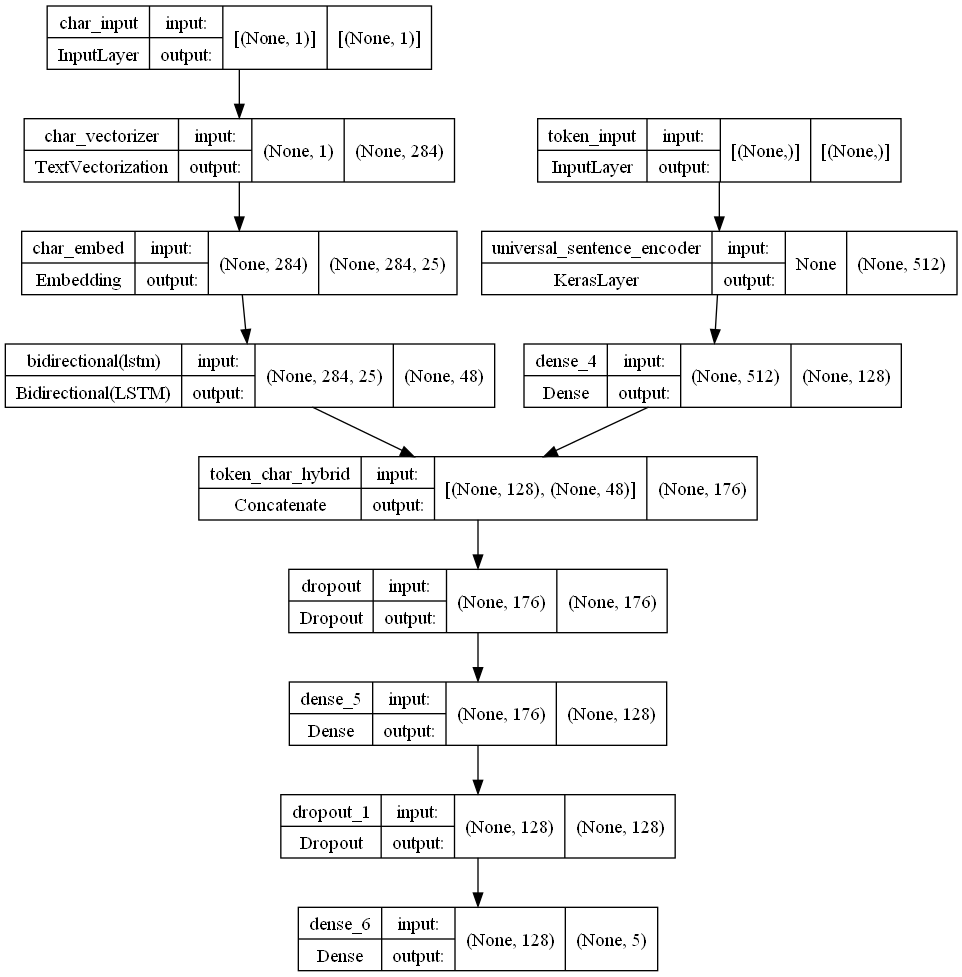

In [100]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

## Model 5: USE + Bidirectional LSTM Tribrid Embedding (Token + Character + Positional Embeddings)

### Create Model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1, 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using the tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities 
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [101]:
train_line_numbers_one_hot[0].shape

TensorShape([15])

In [102]:
train_line_numbers_one_hot[0].dtype

tf.float32

In [103]:
train_total_lines_one_hot[0].shape

TensorShape([20])

In [104]:
train_total_lines_one_hot[0].dtype

tf.float32

In [105]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs) # This is like the embedding layer
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with #5
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output, total_lines_model.output, z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input], outputs=output_layer, name="model_5_tribrid_embedding")

In [106]:
# Get a summary 
model_5.summary()

Model: "model_5_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 284)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_i

In [107]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # Helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Fitting, Evaluating and making Predictions with Tribrid Model

In [108]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
6912/6912 [==============================] - 390s 56ms/step - loss: 0.9389 - accuracy: 0.8313 - val_loss: 0.9068 - val_accuracy: 0.8521
Epoch 2/3
6912/6912 [==============================] - 370s 54ms/step - loss: 0.9051 - accuracy: 0.8540 - val_loss: 0.8962 - val_accuracy: 0.8611
Epoch 3/3
6912/6912 [==============================] - 375s 54ms/step - loss: 0.9002 - accuracy: 0.8571 - val_loss: 0.8877 - val_accuracy: 0.8667


In [109]:
# Make predictions with tribrid model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

array([[0.49839887, 0.07620362, 0.04476186, 0.28327838, 0.09735731],
       [0.11634357, 0.02521771, 0.726089  , 0.09065066, 0.04169908],
       [0.18553804, 0.07076053, 0.1676974 , 0.11369802, 0.46230605],
       ...,
       [0.05039233, 0.3264569 , 0.06766691, 0.0463355 , 0.50914836],
       [0.03322168, 0.24239463, 0.07203001, 0.03453555, 0.6178181 ],
       [0.04580741, 0.81432635, 0.02519242, 0.0217991 , 0.0928747 ]],
      dtype=float32)

In [110]:
# Convert pred probs to labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 4, 4, 1], dtype=int64)>

In [111]:
# Calculate results
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)
model_5_results

{'accuracy': 86.43716300290336,
 'precision': 0.8666037824773485,
 'recall': 0.8643716300290336,
 'f1': 0.8627048165200566}

In [112]:
model_4_results

{'accuracy': 78.84349509193972,
 'precision': 0.7857333825543344,
 'recall': 0.7884349509193972,
 'f1': 0.7857766394825717}

### Model 5 - Visualized

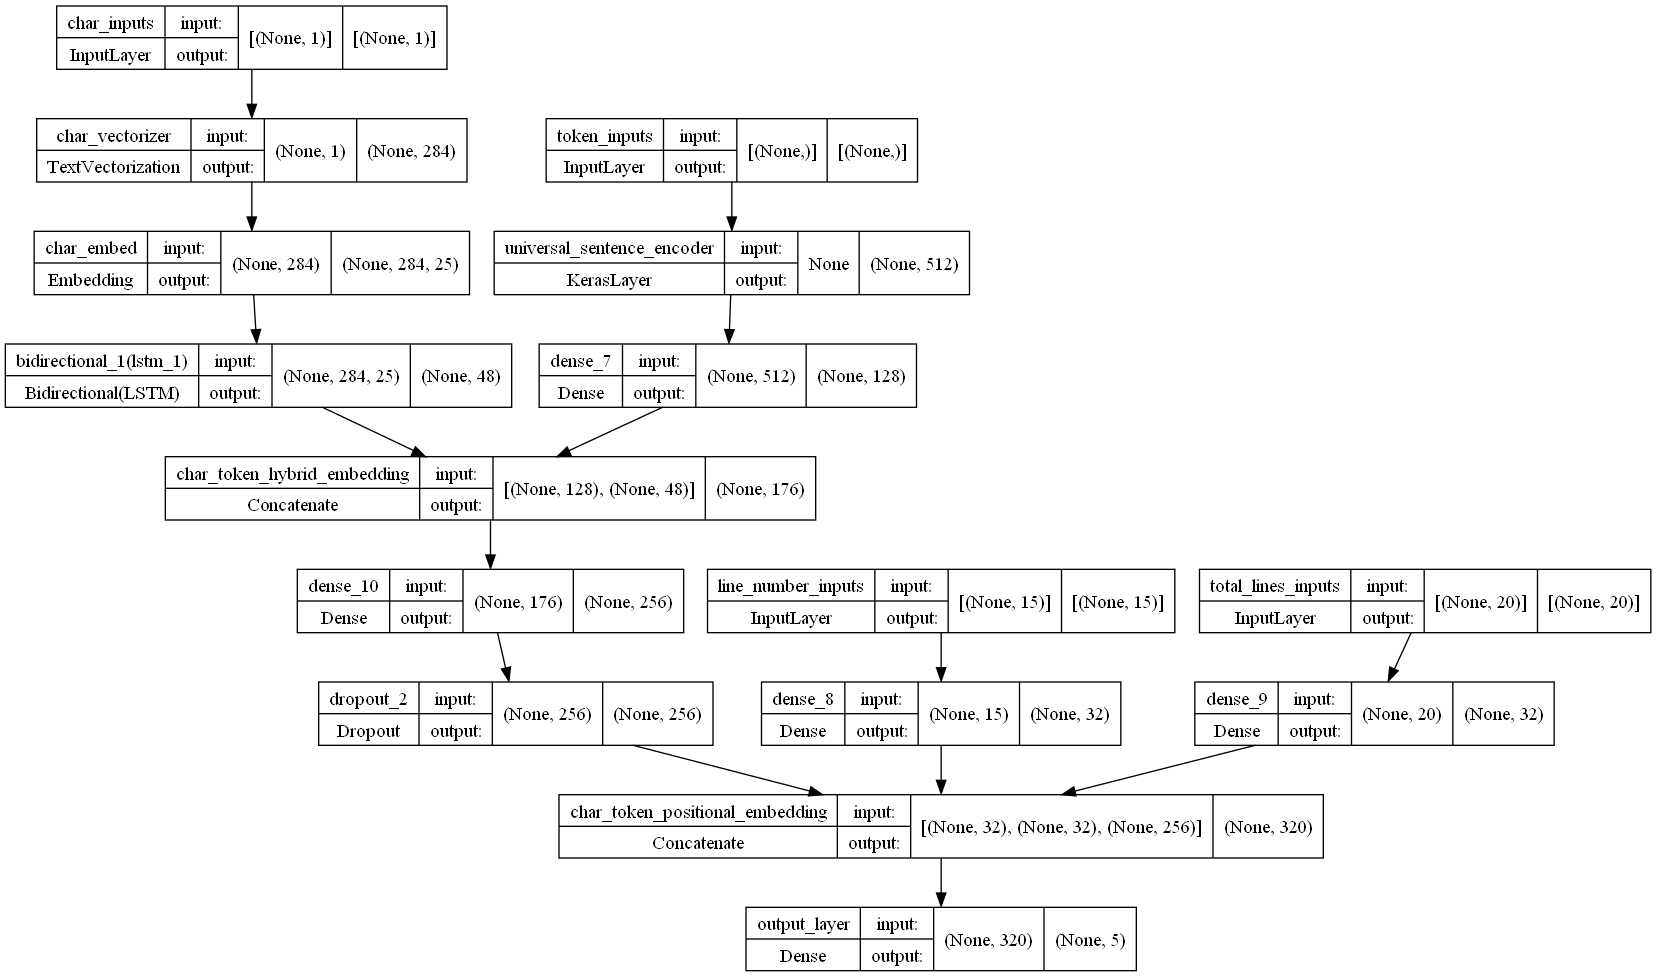

In [113]:
# Plot model 5 visually
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

## Model 6: Custom Token Embeddings + Bidirectional LSTM Tribrid Embedding (Token + Character + Positional Embeddings)

### Create Model

In [130]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
text_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
token_outputs = layers.Dense(128, activation="relu")(x)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs) # This is like the embedding layer
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with #5
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output, total_lines_model.output, z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_6 = tf.keras.Model(inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input], outputs=output_layer, name="model_6_custom_tribrid_embedding")

In [131]:
# Get a summary 
model_6.summary()

Model: "model_6_custom_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 54)          0           ['token_inputs[0][0]']           
 ization)                                                                                         
                                                                                                  
 token_embedding (Embedding)    (None, 54, 128)      8704000     ['text_vectorization[5][0]']     
                                                                                                  
 char_inputs (InputLayer)       [(None, 1)]          0           []

In [132]:
# Compile token, char, and positional embedding model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # Helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [133]:
# Create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3) # If val_loss doesn't decrease for 3 epochs in a row, stop training

In [134]:
# Fit our tribrid embedding model
history_model_6 = model_6.fit(train_char_token_pos_dataset,
                              steps_per_epoch=len(train_char_token_dataset),
                              epochs=100,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=len(val_char_token_pos_dataset),
                              callbacks=[early_stopping])

Epoch 1/100
69121/69121 [==============================] - 2831s 41ms/step - loss: 0.8550 - accuracy: 0.8833 - val_loss: 0.8329 - val_accuracy: 0.8932
Epoch 2/100
69121/69121 [==============================] - 2797s 40ms/step - loss: 0.8364 - accuracy: 0.8956 - val_loss: 0.8316 - val_accuracy: 0.8933
Epoch 3/100
69121/69121 [==============================] - 2857s 41ms/step - loss: 0.8249 - accuracy: 0.9040 - val_loss: 0.8361 - val_accuracy: 0.8891
Epoch 4/100
69121/69121 [==============================] - 2809s 41ms/step - loss: 0.8139 - accuracy: 0.9122 - val_loss: 0.8428 - val_accuracy: 0.8823
Epoch 5/100
69121/69121 [==============================] - 2792s 40ms/step - loss: 0.8034 - accuracy: 0.9202 - val_loss: 0.8481 - val_accuracy: 0.8812


### Evaluate Model

In [135]:
# Make predictions with tribrid model
model_6_pred_probs = model_6.predict(val_char_token_pos_dataset)
model_6_pred_probs

array([[0.53262675, 0.04583345, 0.01874571, 0.37278137, 0.0300127 ],
       [0.10541207, 0.02598411, 0.40081856, 0.12529053, 0.34249476],
       [0.13981661, 0.04336442, 0.08260391, 0.11895419, 0.6152609 ],
       ...,
       [0.05010038, 0.27186385, 0.07251666, 0.03923359, 0.56628555],
       [0.04791923, 0.77396417, 0.05093594, 0.04325765, 0.08392305],
       [0.06494666, 0.81590694, 0.03172586, 0.03443238, 0.05298807]],
      dtype=float32)

In [136]:
# Convert pred probs to labels
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 4, 1, 1], dtype=int64)>

In [137]:
# Calculate results
model_6_results = calculate_results(val_labels_encoded,
                                    model_6_preds)
model_6_results

{'accuracy': 88.12387667634454,
 'precision': 0.881172224941632,
 'recall': 0.8812387667634454,
 'f1': 0.8805361676434648}

### Model 6 - Visualized

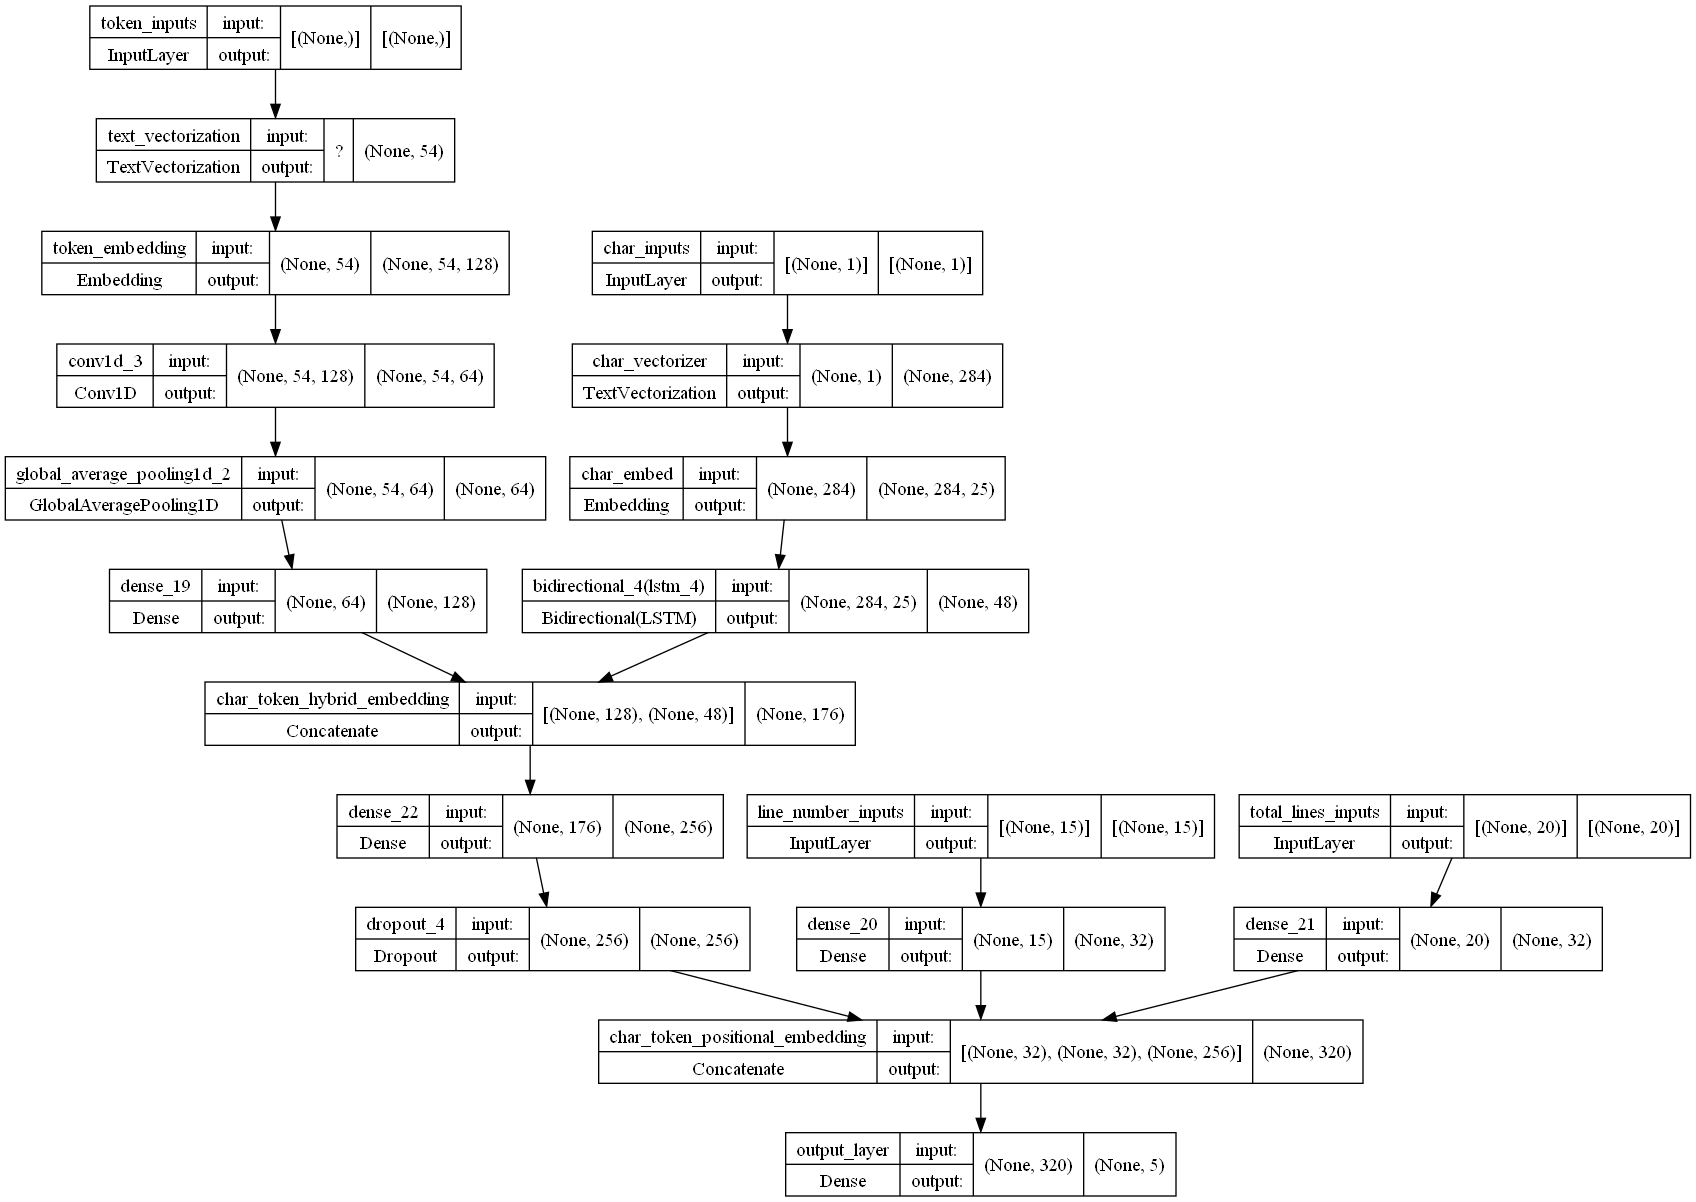

In [126]:
# Plot model 6 visually
plot_model(model_6, show_shapes=True)

## All Model Results - Visualized

In [138]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_tribrid_char_token_pos_embedding": model_5_results,
                                  "model_6_custom_tribrid_embedding": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,74.975805,0.743197,0.749758,0.738957
model_1_custom_token_embedding,83.616757,0.839746,0.836168,0.834180
model_2_pretrained_token_embedding,77.692520,0.774431,0.776925,0.774554
model_3_custom_char_embedding,74.879027,0.740364,0.748790,0.741647
model_4_hybrid_char_token_embedding,78.843495,0.785733,0.788435,0.785777
model_5_tribrid_char_token_pos_embedding,86.437163,0.866604,0.864372,0.862705
model_6_custom_tribrid_embedding,88.123877,0.881172,0.881239,0.880536


In [139]:
# Reduce the accuracy to be same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

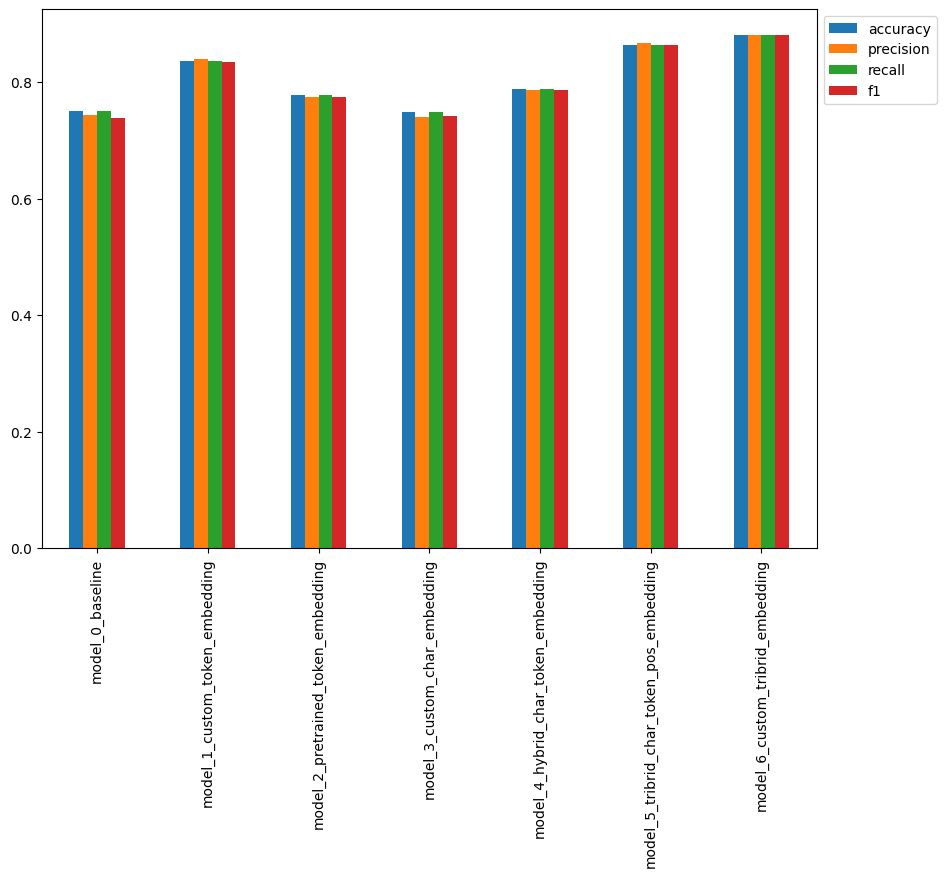

In [140]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

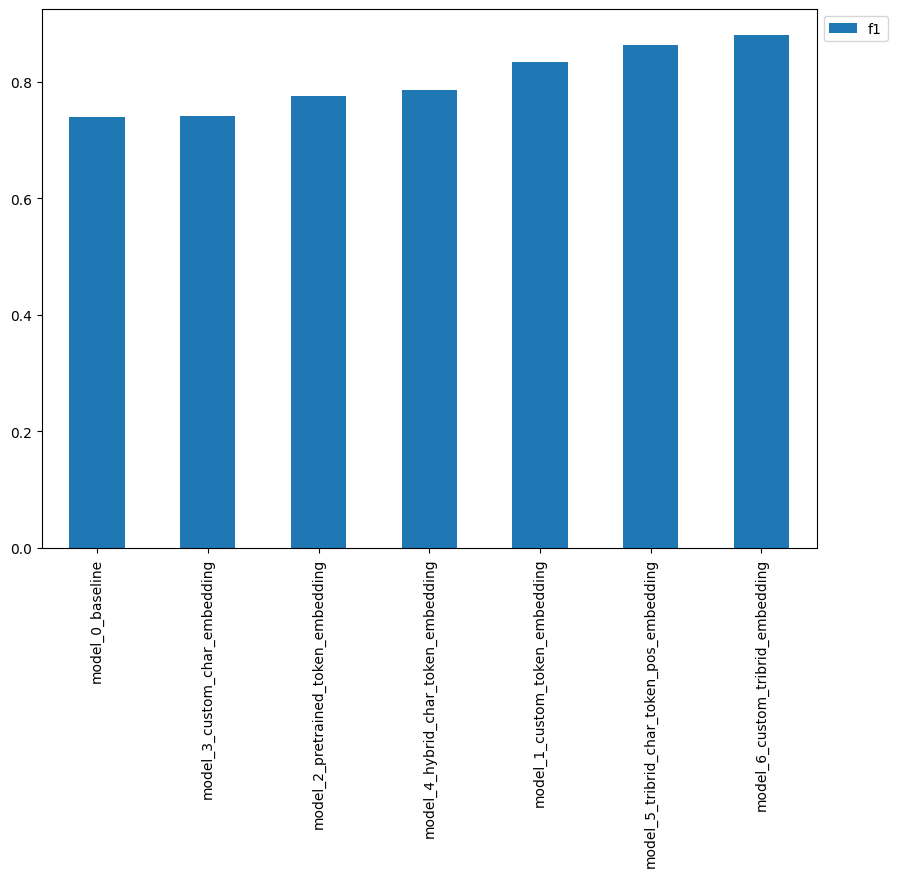

In [141]:
# Sort the model results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

## Save and Load Model

In [ ]:
# Save the best performing model to SavedModel format
model_6.save("skimlit_custom_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets
